# Model 0.13 - Comprehensive Scoring
- Introduce confusion matrix, accuracy, Precision chart
- Basic Feature Importance applied post test data model
- Applied distribution consideration to prediction probabilities
- Applied Kappa weighted prediction to prediction probabilities (~2.5% increase)
- LB 0.402

In [141]:
import re
import itertools
import ml_metrics
import string
import nltk
import scipy
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from functools import lru_cache
from scipy.sparse import hstack
# from scipy.ndimage.filters import gaussian_filter1d as gaussian
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, \
                            accuracy_score, \
                            precision_score, \
                            precision_recall_curve, \
                            log_loss, \
                            roc_auc_score, \
                            roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

In [2]:
# hides warnings - think it needs running after modules imported
import warnings
warnings.simplefilter("ignore")

In [3]:
rnd = 42  # random state for scoring consistency

## Importing the data

In [4]:
df_train = pd.read_csv("../input/train/train.csv", index_col="PetID")
df_test = pd.read_csv("../input/test/test.csv", index_col="PetID")
df_breeds = pd.read_csv("../input/breed_labels.csv", index_col="BreedID")
df_colors = pd.read_csv("../input/color_labels.csv")

In [5]:
colors = df_colors['ColorID']
breeds = df_breeds.index

## Functions

In [6]:
def apply_word_flags(df, words, drop=True):
    """Creates binary columns for words which appear in the description"""
    for word in words:
        df[word] = 0
    for i, desc in df['Description'].items():
        try:
            for word in desc.split():
                word = word.lower()
                if word in words:
                    df.at[i,word] = 1
        except AttributeError:
            continue
    return df.drop(columns=['Description'] if drop else [])

In [7]:
keywords = ['home', 'good' , 'adopt', 'loving', 'give', 'looking', 'playful', 'rescued', 'cat', 'contact']

In [8]:
def apply_color_flags(df, colors):
    """Combines Colors 1,2 & 3 into binary columns for each possible colours"""
    for c in colors:
        df[f'C{c}'] = 0
    for i,colors in df[['Color1', 'Color2', 'Color3']].iterrows():
        for c in colors:
            if c != 0:
                df.at[i,f'C{c}'] = 1
    df = df.drop(columns=['Color1', 'Color2', 'Color3'])
    return df

In [9]:
def create_breed_keywords(df):
    """Creates unique list of keywords from provided breeds dataframe"""
    breed_keywords = []
    for breed in df['BreedName']:
        breed = re.sub(r'[/(/)]', '', breed)  # remove braces
        keywords = breed.split()
        breed_keywords += keywords
    return set(breed_keywords)

In [10]:
def apply_breed_flags(df, keywords, breeds):
    """Creates binary columns for keywords which appear in the breed name"""
    for word in keywords:
        df[word] = 0
        
    for i,pair in df[['Breed1', 'Breed2']].iterrows():
        for indx in pair:
            if indx == 0: continue
            breed = breeds.loc[indx,'BreedName']
            breed = re.sub(r'[/(/)]', '', breed)
            new_keywords = breed.split()
            for word in new_keywords:
                if word in keywords: 
                    df.at[i,word] = 1
                    
    return df

## New Functions

In [477]:
# Kappa weighted prediction, also taking into account natural distribution of training truth values
@lru_cache(maxsize=128)
def quad_weights(i, n=5):
    return 1-(i**2 / (n-1)**2)

def weighted_prediction(proba, defaults):
    prediction = []
    for row in proba:
#         print(row)
        row = [p-defaults[i] if p-defaults[i] > 0 else 0 for i,p in enumerate(row)]
#         row = [p/defaults[i] for i,p in enumerate(row)]
#         print(row)
#         row = [(p-defaults[c])/defaults[c] for c,p in enumerate(row)]
#         print(row)
#         row = np.add(row, abs(min(row)))
#         print(row)
#         input()
#         prediction.append(np.argmax(row))
        k_lst = []
        for i in range(len(row)):
            k_score = sum([p * quad_weights(abs(i-j)) for j, p in enumerate(row)])
            k_lst.append(k_score)
        prediction.append(np.argmax(k_lst))
    return prediction           

## Preparing data

In [11]:
# Combine test and training data
df_combined = pd.concat([df_test, df_train], sort=False)
df_combined['test'] = df_combined['AdoptionSpeed'].isna()
df_combined['Description'] = df_combined['Description'].fillna('')

# Rescuer
rescue_map = Counter(df_combined['RescuerID'])
rescuer_counts = df_combined['RescuerID'].map(rescue_map)

# Breeds
all_test_breeds = df_test['Breed1'].append(df_test['Breed2'])
df_test_breeds = df_breeds.loc[all_test_breeds[all_test_breeds > 0].unique(), :]
breed_keywords = create_breed_keywords(df_test_breeds)

# Prepare data for modelling 
df_combined['rescuer_counts'] = rescuer_counts
df_combined['desc_length'] = df_combined['Description'].apply(len)
df_combined['desc_word_count'] = df_combined['Description'].apply(lambda x: len(x.split()))

df_combined = apply_word_flags(df_combined, keywords, drop=False)
df_combined = apply_color_flags(df_combined, colors)
df_combined = apply_breed_flags(df_combined, breed_keywords, df_breeds)
df_combined = pd.get_dummies(df_combined, columns=['Gender',
                                                   'Vaccinated', 'Dewormed', 'Sterilized', 
                                                   'State'])
y_train_all = df_combined['AdoptionSpeed'][df_combined['test'] != 1]
X_all       = df_combined.drop(columns=['Name', 'RescuerID', 'AdoptionSpeed', 'Breed1', 'Breed2'])
X_train_all = X_all[X_all['test'] != 1].drop(columns=['test'])
X_test_all  = X_all[X_all['test'] == 1].drop(columns=['test'])

In [12]:
# remove description feature
X_train_all = X_train_all.drop(columns=['Description'])
X_test_all  = X_test_all.drop(columns=['Description'])

## Test XGBoost model

In [262]:
params = {'max_depth': 4, 
          'learning_rate': 0.2, 
          'n_estimators': 200, 
          'silent': True, 
          'objective': 'multi:softprob', 
          'booster': 'gbtree',
          'tree_method': 'hist',
          'n_jobs': 3,
          'gamma': 0, 
          'min_child_weight': 1, 
          'max_delta_step': 0, 
          'subsample': 0.8, 
          'colsample_bytree': 1, 
          'colsample_bylevel': 1, 
          'reg_alpha': 0, 
          'reg_lambda': 1, 
          'scale_pos_weight': 1, 
          'base_score': 0.2, 
          'random_state': rnd, 
          'missing': None,
          'verbose': 0,
          'verbosity': 3,}

In [467]:
def cv_testing(X_train_all, params, folds=5, dataframe=True):

    scores = defaultdict(list)

    folds = KFold(folds, True, rnd).split(X_train_all)

    for i, (train_indx, test_indx) in enumerate(folds, 1):
        
        print(f"Fold {i}")
        
        # flag dataframe determines whether to use iloc or "normal" masking for (sparse) arrays
        if not dataframe:
            X_train, X_test = X_train_all[train_indx], X_train_all[test_indx]
            y_train, y_test = y_train_all[train_indx], y_train_all[test_indx]
        else:
            X_train, X_test = X_train_all.iloc[train_indx], X_train_all.iloc[test_indx]
            y_train, y_test = y_train_all.iloc[train_indx], y_train_all.iloc[test_indx]


        clf = xgb.XGBClassifier(**params)

        clf.fit(X_train, y_train)

        prediction = clf.predict(X_test)
        proba = clf.predict_proba(X_test)
        
        # alternative kappa weighted consideration
        total_count = y_train.shape[0]
        defaults = {k:v/total_count for k,v in Counter(y_train).items()}
        prediction = weighted_prediction(proba, defaults)
        

        scores['kappa'].append(ml_metrics.quadratic_weighted_kappa(rater_a=y_test, rater_b=prediction))
        scores['accuracy'].append(accuracy_score(y_test, prediction))
        scores['confusion'].append(confusion_matrix(y_test, prediction))
        scores['precision'].append(precision_score(y_test, prediction, average=None))        
    
    print()
    
    return scores

In [470]:
scores = cv_testing(X_train_all=X_train_all, folds=10, params=params, dataframe=True)

Fold 1
[21:05:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:05:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:05:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 4
[21:05:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 5
[21:05:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 6
[21:05:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 7
[21:05:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 8
[21:06:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 9
[21:06:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 10
[21:06:18] Tree method is selected to be 'hist'

total count: 14993
0: 410
1: 3090
2: 4037
3: 3259
4: 4197


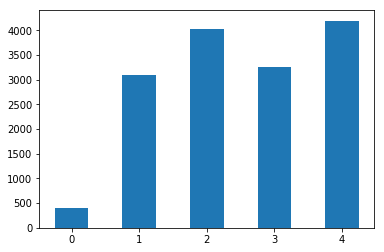

In [340]:
# plot distribution of training categories
distribution = Counter(df_train['AdoptionSpeed'])
items = sorted(distribution.items())
plt.bar(list(map(lambda x: x[0], items)), list(map(lambda x: x[1], items)), width=0.5, align="center")
print(f"total count: {df_train.shape[0]}")
for cat,val in items:
    print(f"{cat}: {val}")

In [283]:
# function from sklearn website example code
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

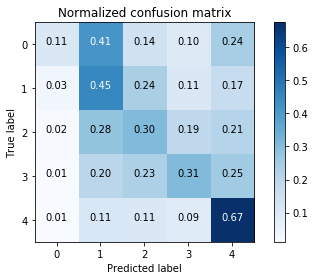

In [471]:
# plot normalised (by row) confusion matrix
cm = sum(scores['confusion'])  # sums element-wise
plt.figure()
plot_confusion_matrix(cm, classes=[0,1,2,3,4], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

<BarContainer object of 5 artists>

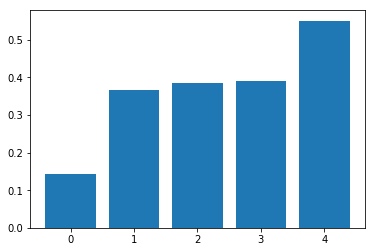

In [472]:
# plot average precision for each class
plt.bar([0,1,2,3,4], sum(scores['precision']) / len(scores['precision']))

In [475]:
# 0.389 --> 0.387 (remove non-important features from test model: ~60 features)
# 0.389 --> 0.413 (apply kappa weighting to proba, subtracting generic 0.2 average distribution)
# 0.389 --> 0.414 (apply kappa weighting to proba, subtracting training distribution)
# 0.389 --> 0.397 (proba distribution adjustment, subtracting training distribution)
print("kappa:    {:.3}".format(np.mean(scores['kappa'])))
print("accuracy: {:.3}".format(np.mean(scores['accuracy'])))

kappa:    0.397
accuracy: 0.433


# Run model on test data

In [478]:
clf = xgb.XGBClassifier(**params)
clf.fit(X_train_all, y_train_all)
proba = clf.predict_proba(X_test_all)
# distribution and kappa weighted consideration
total_count = y_train_all.shape[0]
defaults = {k:v/total_count for k,v in Counter(y_train_all).items()}
prediction = weighted_prediction(proba, defaults)

[21:10:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


In [41]:
clf.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=3, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8, tree_method='hist', verbose=0,
       verbosity=3)>

# Model Analysis

### Feature Importance

In [ ]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train_all.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
# top 10 features
feature_importances.iloc[:10,:][::-1].plot.barh()

In [ ]:
# distribution of feature importance
feature_importances.plot()

In [ ]:
# bottom 10 least important features
feature_importances[feature_importances['importance'] > 0].iloc[-10:,:][::-1].plot.barh()

In [ ]:
# count of non-importance features
not_important = feature_importances[feature_importances['importance'] == 0]
len(not_important)

In [ ]:
not_important.index

In [ ]:
# X_train_all = X_train_all.drop(columns=list(not_important.index))
# X_test_all = X_test_all.drop(columns=list(not_important.index))

# Final run on test model and submission

In [482]:
clf = xgb.XGBClassifier(**params)
clf.fit(X_train_all, y_train_all)
proba = clf.predict_proba(X_test_all)
# distribution and kappa weighted consideration
total_count = y_train_all.shape[0]
defaults = {k:v/total_count for k,v in Counter(y_train_all).items()}
prediction = np.array(weighted_prediction(proba, defaults))

[21:11:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


In [484]:
submission = pd.DataFrame({'AdoptionSpeed': prediction.astype(int)}, index=X_test_all.index)
submission.to_csv("submission.csv", index=True, index_label='PetID', header=['AdoptionSpeed'])